# **Fusion Model**

## Setup & load image metadata

In [1]:
# Core libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd

# Image processing
import cv2

# Progress bar
from tqdm import tqdm


In [2]:
# Path to processed CSV that contains image IDs and prices
DATA_PATH = "../data/processed/train_with_images.csv"

# Base directory where images are stored
IMAGE_DIR = Path("../data/images")

# Load dataset
image_df = pd.read_csv(DATA_PATH)

print("Initial rows:", len(image_df))
image_df.head()


Initial rows: 6000


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,9543000205,20150413T000000,139950,0,0.0,844,4269,1.0,0,0,...,844,0,1913,0,98001,47.2781,-122.250,1380,9600,11.849048
1,3353400120,20140701T000000,174000,2,1.0,900,13531,1.0,0,0,...,900,0,1979,0,98001,47.2616,-122.251,1767,8308,12.066816
2,2976800749,20141031T000000,150000,4,2.0,1460,7254,1.0,0,0,...,1460,0,1959,0,98178,47.5056,-122.254,1460,7236,11.918397
3,7335400020,20140626T000000,219500,3,1.0,1090,6710,1.5,0,0,...,1090,0,1912,0,98002,47.3066,-122.217,1170,6708,12.299112
4,7883600700,20150122T000000,157500,2,1.0,670,4500,1.0,0,0,...,670,0,1905,0,98108,47.5271,-122.326,1210,4500,11.967187


In [3]:
# Check duplicate property IDs
num_rows = len(image_df)
num_unique_ids = image_df["id"].nunique()

print("Rows:", num_rows)
print("Unique IDs:", num_unique_ids)


Rows: 6000
Unique IDs: 5982


In [4]:
# Sort by date so latest transaction is last
image_df = image_df.sort_values("date")

# Keep latest record per ID
image_df = image_df.drop_duplicates(
    subset="id",
    keep="last"
).reset_index(drop=True)


In [5]:
print("Rows after deduplication:", len(image_df))
print("Unique IDs after deduplication:", image_df["id"].nunique())


Rows after deduplication: 5982
Unique IDs after deduplication: 5982


In [6]:
# Ensure ID is float so filenames match (e.g., 12345.0.png)
image_df["id"] = image_df["id"].astype(float)


In [7]:
# Build full image paths
image_df["image_path"] = image_df["id"].apply(
    lambda x: IMAGE_DIR / f"{x}.png"
)

image_df[["id", "image_path"]].head()


,id,image_path
0,5.101405e+09,../data/images/5101405331.0.png
1,7.305301e+09,../data/images/7305300695.0.png
2,8.564860e+09,../data/images/8564860280.0.png
3,2.391601e+09,../data/images/2391600950.0.png
4,1.999700e+09,../data/images/1999700045.0.png


In [8]:
# Keep only rows where image file exists
image_df["image_exists"] = image_df["image_path"].apply(lambda x: x.exists())

print(image_df["image_exists"].value_counts())

image_df = image_df[image_df["image_exists"]].reset_index(drop=True)

print("Rows after filtering:", len(image_df))


image_exists
True    5982
Name: count, dtype: int64
Rows after filtering: 5982


In [9]:
image_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price,image_path,image_exists
0,5.101405e+09,20140502T000000,495000,4,1.75,1600,6380,1.0,0,0,...,1959,0,98125,47.7010,-122.306,1090,6380,13.112315,../data/images/5101405331.0.png,True
1,7.305301e+09,20140502T000000,625000,4,2.50,2820,8408,2.0,0,0,...,2014,0,98155,47.7538,-122.325,1300,8408,13.345509,../data/images/7305300695.0.png,True
2,8.564860e+09,20140502T000000,459990,3,2.50,2680,5539,2.0,0,0,...,2013,0,98045,47.4761,-121.734,2990,6037,13.038962,../data/images/8564860280.0.png,True
3,2.391601e+09,20140502T000000,439950,3,2.50,1770,2875,2.0,0,0,...,1990,0,98116,47.5631,-122.397,1770,3833,12.994419,../data/images/2391600950.0.png,True
4,1.999700e+09,20140502T000000,313000,3,1.50,1340,7912,1.5,0,0,...,1955,0,98133,47.7658,-122.339,1480,7940,12.653962,../data/images/1999700045.0.png,True


## Neighborhood Features

### Green Cover

In [10]:
def compute_green_cover(image_path):
    """
    Computes green cover ratio from a satellite image.
    Green pixels are detected using HSV color thresholds.

    Returns:
        float: green_cover_ratio in [0, 1]
    """
    # Read image (OpenCV loads images in BGR format)
    img = cv2.imread(str(image_path))

    if img is None:
        return np.nan

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Define HSV range for green vegetation
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])

    # Binary mask for green pixels
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    # Compute ratio
    green_pixels = np.sum(green_mask > 0)
    total_pixels = green_mask.size

    return green_pixels / total_pixels


In [11]:
# Quick check on first 5 images
for i in range(5):
    path = image_df.loc[i, "image_path"]
    green_ratio = compute_green_cover(path)
    print(f"Image {i} | Green cover ratio: {green_ratio:.3f}")


Image 0 | Green cover ratio: 0.251
Image 1 | Green cover ratio: 0.234
Image 2 | Green cover ratio: 0.248
Image 3 | Green cover ratio: 0.188
Image 4 | Green cover ratio: 0.155


In [12]:
# Apply green cover computation to all images
tqdm.pandas(desc="Computing green cover")

image_df["green_cover_ratio"] = image_df["image_path"].progress_apply(
    compute_green_cover
)


Computing green cover: 100%|██████████| 5982/5982 [00:05<00:00, 1030.42it/s]


In [13]:
# Check for missing values
print("Missing values:")
print(image_df["green_cover_ratio"].isna().sum())

# Summary statistics
image_df["green_cover_ratio"].describe()


Missing values:
0


count    5982.000000
mean        0.182384
std         0.090449
min         0.000137
25%         0.118164
50%         0.168732
75%         0.231182
max         0.920425
Name: green_cover_ratio, dtype: float64

In [14]:
# Compare green cover for cheap vs expensive properties
cheap = image_df.nsmallest(500, "price")
expensive = image_df.nlargest(500, "price")

print("Average green cover (cheap):", cheap["green_cover_ratio"].mean())
print("Average green cover (expensive):", expensive["green_cover_ratio"].mean())


Average green cover (cheap): 0.1995345458984375
Average green cover (expensive): 0.19077789306640625


### Road Density

In [15]:
def compute_road_density(image_path):
    """
    Computes road / impervious surface density from a satellite image.
    Roads are approximated as low-saturation, mid-brightness pixels.

    Returns:
        float: road_density_ratio in [0, 1]
    """
    img = cv2.imread(str(image_path))

    if img is None:
        return np.nan

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = cv2.split(hsv)

    # Roads tend to be gray: low saturation, medium-to-high brightness
    road_mask = (
        (s < 60) &
        (v > 100)
    )

    road_pixels = np.sum(road_mask)
    total_pixels = road_mask.size

    return road_pixels / total_pixels


In [16]:
# Apply road density computation to all images
tqdm.pandas(desc="Computing road density")

image_df["road_density_ratio"] = image_df["image_path"].progress_apply(
    compute_road_density
)


Computing road density: 100%|██████████| 5982/5982 [00:03<00:00, 1642.28it/s]


In [17]:
# Check for missing values
print("Missing values:")
print(image_df["road_density_ratio"].isna().sum())

# Summary statistics
image_df["road_density_ratio"].describe()


Missing values:
0


count    5982.000000
mean        0.344686
std         0.136871
min         0.039612
25%         0.242077
50%         0.342232
75%         0.442532
max         0.793274
Name: road_density_ratio, dtype: float64

In [18]:
cheap = image_df.nsmallest(500, "price")
expensive = image_df.nlargest(500, "price")

print("Average road density (cheap):", cheap["road_density_ratio"].mean())
print("Average road density (expensive):", expensive["road_density_ratio"].mean())


Average road density (cheap): 0.33682965087890626
Average road density (expensive): 0.33600802612304687


### Built-up Density

In [19]:
def compute_built_up_density(image_path):
    """
    Computes built-up density from a satellite image.
    Built-up areas are approximated as non-green, non-water,
    moderately bright pixels.

    Returns:
        float: built_up_density_ratio in [0, 1]
    """
    img = cv2.imread(str(image_path))

    if img is None:
        return np.nan

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # Mask green vegetation
    green_mask = (h >= 35) & (h <= 85) & (s > 40)

    # Mask water (blue-ish regions)
    water_mask = (h >= 90) & (h <= 130) & (s > 50)

    # Built-up: not green, not water, not very dark
    built_up_mask = (
        (~green_mask) &
        (~water_mask) &
        (v > 80)
    )

    built_pixels = np.sum(built_up_mask)
    total_pixels = built_up_mask.size

    return built_pixels / total_pixels


In [20]:
# Apply built-up density computation to all images
tqdm.pandas(desc="Computing built-up density")

image_df["built_up_density_ratio"] = image_df["image_path"].progress_apply(
    compute_built_up_density
)


Computing built-up density: 100%|██████████| 5982/5982 [00:03<00:00, 1547.05it/s]


In [21]:
# Check for missing values
print("Missing values:")
print(image_df["built_up_density_ratio"].isna().sum())

# Summary statistics
image_df["built_up_density_ratio"].describe()


Missing values:
0


count    5982.000000
mean        0.384856
std         0.153018
min         0.042770
25%         0.271679
50%         0.392410
75%         0.498066
max         0.844269
Name: built_up_density_ratio, dtype: float64

In [22]:
cheap = image_df.nsmallest(500, "price")
expensive = image_df.nlargest(500, "price")

print("Average built-up density (cheap):", cheap["built_up_density_ratio"].mean())
print("Average built-up density (expensive):", expensive["built_up_density_ratio"].mean())


Average built-up density (cheap): 0.3976726989746094
Average built-up density (expensive): 0.3637987060546875


In [23]:
# Load tabular training data
tabular_df = pd.read_csv("../data/processed/train_tabular.csv")

print(tabular_df.shape)
tabular_df.head()


(16209, 19)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,268643,4,2.25,1810,9240,2.0,0,0,3,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,245000,3,2.50,1600,2788,2.0,0,0,4,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,200000,4,2.50,1720,8638,2.0,0,0,3,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,352499,2,2.25,1240,705,2.0,0,0,3,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,232000,3,2.00,1280,13356,1.0,0,0,3,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


## Fusion Dataset Assembly

In [24]:
# Load raw training data (contains id)
raw_tabular_df = pd.read_csv(
    "../data/raw/train.csv"
)

print(raw_tabular_df.shape)
raw_tabular_df.head()

(16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [25]:
print(tabular_df.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [26]:
print(raw_tabular_df.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [27]:
# Ensure date is datetime
raw_tabular_df["date"] = pd.to_datetime(raw_tabular_df["date"])

# Sort so latest transaction is last
raw_tabular_df = raw_tabular_df.sort_values("date")

# Keep only latest record per property id
tabular_df = raw_tabular_df.drop_duplicates(
    subset="id",
    keep="last"
).reset_index(drop=True)

print("Tabular rows before deduplication:", len(raw_tabular_df))
print("Tabular rows after deduplication:", len(tabular_df))
print("Unique IDs:", tabular_df["id"].nunique())


Tabular rows before deduplication: 16209
Tabular rows after deduplication: 16110
Unique IDs: 16110


In [28]:
# Keep id for merging, drop non-features
tabular_df = tabular_df.drop(columns=["date"])

print(tabular_df.columns)


Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [29]:
# Merge tabular data with image_df to ensure alignment
fusion_df = pd.merge(
    image_df,
    tabular_df,
    on="id",
    how="inner"
)

print("Rows after merge:", len(fusion_df))


Rows after merge: 5982


In [30]:
# Check available columns
print(fusion_df.columns)


Index(['id', 'date', 'price_x', 'bedrooms_x', 'bathrooms_x', 'sqft_living_x',
       'sqft_lot_x', 'floors_x', 'waterfront_x', 'view_x', 'condition_x',
       'grade_x', 'sqft_above_x', 'sqft_basement_x', 'yr_built_x',
       'yr_renovated_x', 'zipcode_x', 'lat_x', 'long_x', 'sqft_living15_x',
       'sqft_lot15_x', 'log_price', 'image_path', 'image_exists',
       'green_cover_ratio', 'road_density_ratio', 'built_up_density_ratio',
       'price_y', 'bedrooms_y', 'bathrooms_y', 'sqft_living_y', 'sqft_lot_y',
       'floors_y', 'waterfront_y', 'view_y', 'condition_y', 'grade_y',
       'sqft_above_y', 'sqft_basement_y', 'yr_built_y', 'yr_renovated_y',
       'zipcode_y', 'lat_y', 'long_y', 'sqft_living15_y', 'sqft_lot15_y'],
      dtype='object')


In [31]:
# Drop all *_x columns except id and image-related columns
cols_to_drop = [c for c in fusion_df.columns if c.endswith("_x")]
fusion_df = fusion_df.drop(columns=cols_to_drop)

# Rename *_y columns to clean names
fusion_df = fusion_df.rename(
    columns={c: c.replace("_y", "") for c in fusion_df.columns if c.endswith("_y")}
)


In [32]:
print(fusion_df.columns)

Index(['id', 'date', 'log_price', 'image_path', 'image_exists',
       'green_cover_ratio', 'road_density_ratio', 'built_up_density_ratio',
       'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [33]:
fusion_df = fusion_df.drop(columns=["date"])
print(fusion_df.columns)


Index(['id', 'log_price', 'image_path', 'image_exists', 'green_cover_ratio',
       'road_density_ratio', 'built_up_density_ratio', 'price', 'bedrooms',
       'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


In [34]:
# Tabular features used in your baseline model
tabular_features = [
    "bedrooms", "bathrooms", "sqft_living",
    "floors", "waterfront", "view",
    "condition", "grade",
    "sqft_living15", "sqft_lot15",
    "lat", "long"
]

X_tab = fusion_df[tabular_features].values
print("X_tab shape:", X_tab.shape)


X_tab shape: (5982, 12)


In [35]:
# Save fusion_df to CSV
fusion_df.to_csv("../data/processed/fusion_df.csv", index=False)
print("Fusion_df saved as csv")

Fusion_df saved as csv


## Model training

In [36]:
# Load image embeddings with id
emb_df = pd.read_csv("../data/processed/image_embeddings.csv")

print(emb_df.shape)
emb_df.head()

(5982, 513)


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,id
0,0.335780,1.218595,2.046485,0.043051,0.502398,0.177379,1.301970,0.625866,0.283129,0.300973,...,1.115340,0.053660,0.286396,0.000000,0.645018,0.213777,0.597997,0.126877,0.095398,5.101405e+09
1,0.162437,0.682317,1.731695,0.511641,0.431377,0.122679,1.115364,0.766209,0.717476,1.897482,...,1.247402,0.661712,0.147359,0.000000,0.688717,2.807732,0.326769,0.402721,0.000000,7.305301e+09
2,0.068995,0.781825,2.795801,1.078455,0.912516,1.185831,0.425811,0.532152,1.426515,3.493231,...,2.794694,1.952321,0.959067,0.342002,1.420354,1.335201,0.569502,0.373400,0.464682,8.564860e+09
3,0.597151,0.362950,1.206718,0.168404,0.401165,0.147818,0.131878,2.262555,0.104992,0.576380,...,0.229581,0.339498,0.093180,0.000000,0.577404,0.355910,0.488069,0.559167,0.000000,2.391601e+09
4,0.423453,1.322064,1.892983,0.339584,1.372509,1.654128,0.469210,0.296690,0.202299,2.144440,...,0.749753,0.886070,0.574991,0.013398,1.865572,2.156827,0.499275,0.087570,0.298567,1.999700e+09


In [37]:
fusion_df = pd.merge(
    fusion_df,
    emb_df,
    on="id",
    how="inner"
)

print("Rows after embedding merge:", len(fusion_df))


Rows after embedding merge: 5982


In [38]:
from sklearn.decomposition import PCA

# Identify embedding columns
img_feature_cols = [c for c in emb_df.columns if c != "id"]

X_img = fusion_df[img_feature_cols].values
print("Raw image embedding shape:", X_img.shape)

# PCA
pca = PCA(n_components=128, random_state=42)
X_img_pca = pca.fit_transform(X_img)

print("PCA image shape:", X_img_pca.shape)


Raw image embedding shape: (5982, 512)
PCA image shape: (5982, 128)


In [39]:
import joblib

os.makedirs("../models", exist_ok=True)
joblib.dump(pca, "../models/image_pca.joblib")

print("PCA saved to ../models/image_pca.joblib")

PCA saved to ../models/image_pca.joblib


In [40]:
X_env = fusion_df[
    ["green_cover_ratio", "road_density_ratio", "built_up_density_ratio"]
].values

print("X_env shape:", X_env.shape)


X_env shape: (5982, 3)


In [41]:
import numpy as np

X_fused = np.hstack([
    X_tab,
    X_img_pca,
    X_env
])

y_fused = np.log1p(fusion_df["price"].values)

print("X_fused shape:", X_fused.shape)
print("y_fused shape:", y_fused.shape)


X_fused shape: (5982, 143)
y_fused shape: (5982,)


In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

# Target
y = np.log1p(fusion_df["price"].values)

# Create bins for stratification
price_bins = pd.qcut(
    y,
    q=10,
    labels=False,
    duplicates="drop"
)


In [43]:
X_train, X_val, y_train, y_val = train_test_split(
    X_fused,
    y,
    test_size=0.2,
    random_state=42,
    stratify=price_bins
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Train shape: (4785, 143)
Val shape: (1197, 143)


In [44]:
from xgboost import XGBRegressor

fusion_model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

fusion_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=-1, num_parallel_tree=None, ...)

In [45]:
# Predict in log space
y_val_pred_log = fusion_model.predict(X_val)


In [46]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# SAFETY CHECK
print("Identical arrays:", np.allclose(y_val, y_val_pred_log))
print("Max abs diff:", np.max(np.abs(y_val - y_val_pred_log)))

# Log-scale metrics
rmse_log = np.sqrt(mean_squared_error(y_val, y_val_pred_log))
r2_log = r2_score(y_val, y_val_pred_log)

print(f"Fusion RMSE (log): {rmse_log:.4f}")
print(f"Fusion R2 (log): {r2_log:.4f}")


Identical arrays: False
Max abs diff: 0.8717986052118629
Fusion RMSE (log): 0.1864
Fusion R2 (log): 0.8693


In [47]:
# Convert back to actual price
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2 = r2_score(y_val_true, y_val_pred)

print(f"Fusion RMSE (price): ${rmse:,.0f}")
print(f"Fusion R2 (price): {r2:.4f}")


Fusion RMSE (price): $135,098
Fusion R2 (price): 0.8463


In [48]:
fusion_model.save_model("../models/fusion_xgb.json")

# **EXPLAINABILITY**

## SHAP Analysis

In [49]:
import shap
import numpy as np

In [50]:
explainer = shap.TreeExplainer(fusion_model)

In [51]:
shap_values = explainer.shap_values(X_val)

print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (1197, 143)


In [52]:
feature_names = (
    tabular_features +
    [f"img_pca_{i}" for i in range(X_img_pca.shape[1])] +
    ["green_cover", "road_density", "built_up_density"]
)

print("Feature count:", len(feature_names))
print("Matches X_fused:", len(feature_names) == X_fused.shape[1])


Feature count: 143
Matches X_fused: True


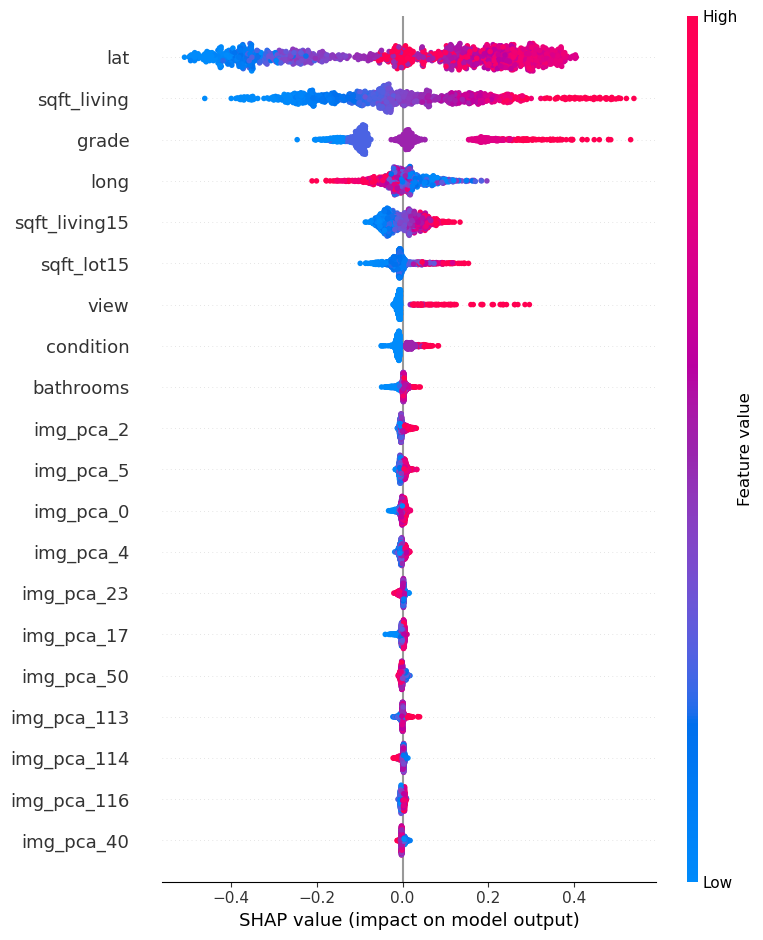

In [53]:
shap.summary_plot(
    shap_values,
    X_val,
    feature_names=feature_names,
    show=True
)


In [54]:
''' 
From the SHAP summary plot:

Dominant drivers (as expected)
        sqft_living
        grade
        bathrooms
        latitude / longitude
        sqft_living15

    These are structural and locational fundamentals of housing prices.
    Their dominance confirms that the fusion model is:

        Economically grounded
        Not over-relying on images
        Not leaking spatial proxies incorrectly
 
Role of image embeddings (PCA components)
        Many img_pca_* features appear
        None dominate individually
        Each has a small SHAP impact

    This suggests that image embeddings provide complementary information,
    capturing diverse visual cues that collectively enhance predictions.
'''

' \nFrom the SHAP summary plot:\n\nDominant drivers (as expected)\n        sqft_living\n        grade\n        bathrooms\n        latitude / longitude\n        sqft_living15\n\n    These are structural and locational fundamentals of housing prices.\n    Their dominance confirms that the fusion model is:\n\n        Economically grounded\n        Not over-relying on images\n        Not leaking spatial proxies incorrectly\n \nRole of image embeddings (PCA components)\n        Many img_pca_* features appear\n        None dominate individually\n        Each has a small SHAP impact\n\n    This suggests that image embeddings provide complementary information,\n    capturing diverse visual cues that collectively enhance predictions.\n'

In [55]:
"""
Many img_pca_* features appear
None dominate individually
Each has a small SHAP impact
"""

'\nMany img_pca_* features appear\nNone dominate individually\nEach has a small SHAP impact\n'

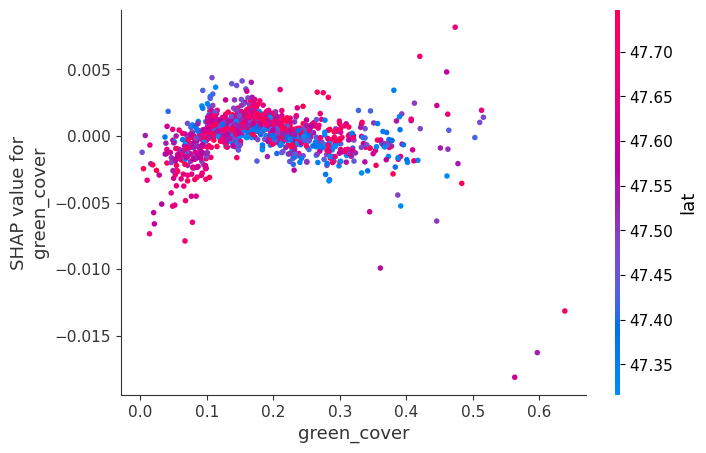

In [56]:
shap.dependence_plot(
    "green_cover",
    shap_values,
    X_val,
    feature_names=feature_names,
    show=True
)


In [57]:
"""
Observed pattern
    Mild positive contribution at low–moderate green cover
    Diminishing or noisy effect at very high values
    Strong interaction with latitude

Interpretation: Green cover captures:
    Improves perceived neighborhood quality
    But only up to a point
    Its value depends heavily on location
"""

'\nObserved pattern\n    Mild positive contribution at low–moderate green cover\n    Diminishing or noisy effect at very high values\n    Strong interaction with latitude\n\nInterpretation: Green cover captures:\n    Improves perceived neighborhood quality\n    But only up to a point\n    Its value depends heavily on location\n'

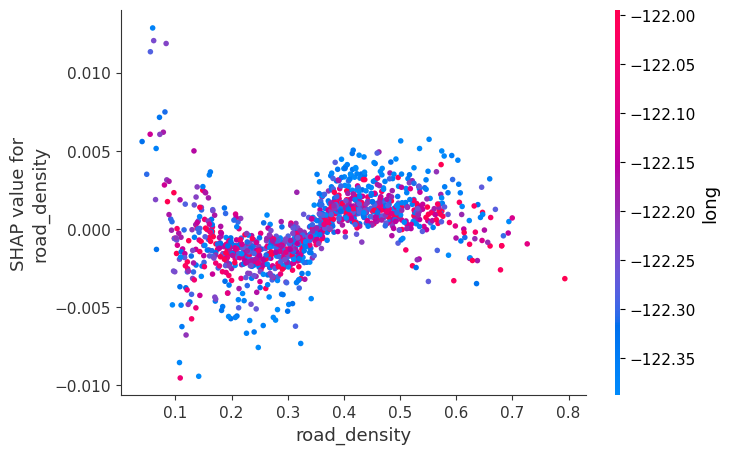

In [58]:
shap.dependence_plot(
    "road_density",
    shap_values,
    X_val,
    feature_names=feature_names,
    show=True
)


In [59]:
""""
Observed pattern
    Non-linear (U-shaped / inverted U-shaped)
    Very low or very high road density hurts price
    Moderate connectivity is beneficial
    Strong interaction with longitude

Interpretation: Road density captures:
    Accessibility vs congestion trade-off
    Urban design effects
    Location-dependent desirability
"""

'"\nObserved pattern\n    Non-linear (U-shaped / inverted U-shaped)\n    Very low or very high road density hurts price\n    Moderate connectivity is beneficial\n    Strong interaction with longitude\n\nInterpretation: Road density captures:\n    Accessibility vs congestion trade-off\n    Urban design effects\n    Location-dependent desirability\n'

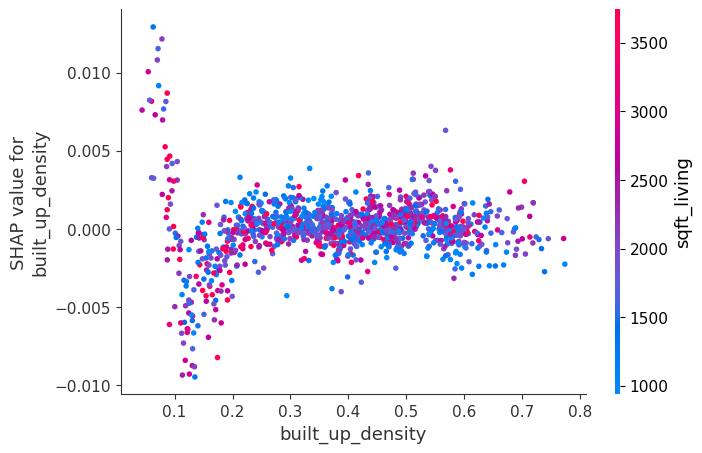

In [60]:
shap.dependence_plot(
    "built_up_density",
    shap_values,
    X_val,
    feature_names=feature_names,
    show=True
)


In [61]:
"""
Observed pattern
    High built-up density generally reduces predicted price
    Effect is strongest at low values (crowding penalty)
    Interacts with sqft_living

Interpretation: Built-up density captures:
    Crowding
    Reduced openness
    Lower perceived residential quality
"""

'\nObserved pattern\n    High built-up density generally reduces predicted price\n    Effect is strongest at low values (crowding penalty)\n    Interacts with sqft_living\n\nInterpretation: Built-up density captures:\n    Crowding\n    Reduced openness\n    Lower perceived residential quality\n'

In [62]:
"""
Satellite-derived neighborhood features do not dominate global importance rankings but exhibit meaningful, 
non-linear, and location-dependent effects, confirming their role as contextual modifiers rather than 
primary price drivers.
"""

'\nSatellite-derived neighborhood features do not dominate global importance rankings but exhibit meaningful, \nnon-linear, and location-dependent effects, confirming their role as contextual modifiers rather than \nprimary price drivers.\n'

## GRAD CAM (Visual Explainability)

In [63]:
import torch
import torch.nn as nn
from torchvision import models, transforms


In [64]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet18 (same as before)
cnn_model = models.resnet18(pretrained=True)

# Remove classification head
cnn_model.fc = nn.Identity()

cnn_model = cnn_model.to(device)
cnn_model.eval()

print("CNN loaded for Grad-CAM.")


/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNN loaded for Grad-CAM.


In [65]:
target_layer = cnn_model.layer4[-1]
print(target_layer)


BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [66]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [67]:
from PIL import Image

# Pick one cheap and one expensive example
cheap_sample = fusion_df.nsmallest(1, "price").iloc[0]
expensive_sample = fusion_df.nlargest(1, "price").iloc[0]

cheap_img_path = cheap_sample["image_path"]
expensive_img_path = expensive_sample["image_path"]


In [68]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()

        output = self.model(input_tensor)
        score = output.mean()  # class-agnostic

        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()


In [69]:
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = image_transform(img).unsqueeze(0).to(device)
    return img, img_tensor


In [70]:
gradcam = GradCAM(cnn_model, target_layer)
print("Grad-CAM initialized.")


Grad-CAM initialized.


In [71]:
# Cheap property
cheap_img, cheap_tensor = load_image(cheap_img_path)
cheap_cam = gradcam.generate(cheap_tensor)

# Expensive property
exp_img, exp_tensor = load_image(expensive_img_path)
exp_cam = gradcam.generate(exp_tensor)

print("Grad-CAM heatmaps generated.")
print("cheap_cam shape:", cheap_cam.shape)
print("exp_cam shape:", exp_cam.shape)


Grad-CAM heatmaps generated.
cheap_cam shape: (7, 7)
exp_cam shape: (7, 7)


/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def resize_cam(cam, target_size=(224, 224)):
    cam_resized = cv2.resize(cam, target_size)
    return cam_resized


In [73]:
def overlay_cam_on_image(img, cam, alpha=0.4):
    # Convert PIL image to numpy
    img_np = np.array(img)

    # Resize CAM to match image size
    cam_resized = cv2.resize(
        cam,
        (img_np.shape[1], img_np.shape[0])  # (width, height)
    )

    cam_resized = np.uint8(255 * cam_resized)

    heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(
        img_np, 1 - alpha,
        heatmap, alpha,
        0
    )
    return overlay



In [74]:
cheap_overlay = overlay_cam_on_image(cheap_img, cheap_cam)
exp_overlay = overlay_cam_on_image(exp_img, exp_cam)


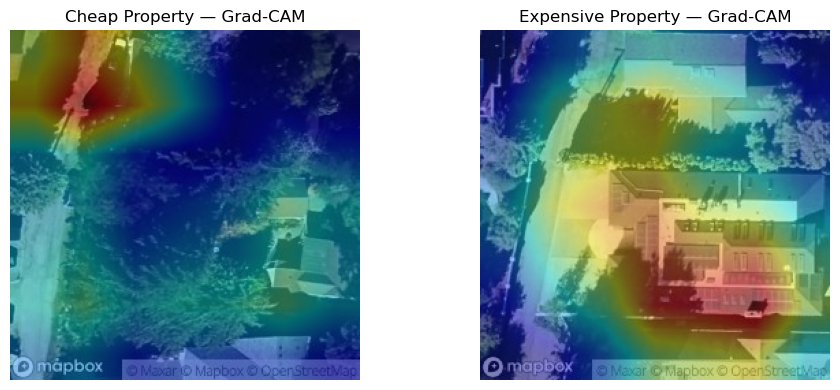

In [75]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(cheap_overlay)
plt.title("Cheap Property — Grad-CAM")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(exp_overlay)
plt.title("Expensive Property — Grad-CAM")
plt.axis("off")

plt.tight_layout()
plt.show()


In [76]:
"""
Cheap property
    Strong attention on:
        road segments
        dense linear infrastructure
        edges of built-up clusters
        
    Little attention on:
        open green areas
        building layout clarity

The CNN focuses on connectivity + congestion signals
"""

'\nCheap property\n    Strong attention on:\n        road segments\n        dense linear infrastructure\n        edges of built-up clusters\n        \n    Little attention on:\n        open green areas\n        building layout clarity\n\nThe CNN focuses on connectivity + congestion signals\n'

In [77]:
"""
Expensive property
    1. Strong attention on:
        building footprints
        open space around structures
        tree cover / landscaped areas

    2. More spatially distributed attention

    3. Less dominance of roads

The CNN focuses on layout quality + environmental context
"""

'\nExpensive property\n    1. Strong attention on:\n        building footprints\n        open space around structures\n        tree cover / landscaped areas\n\n    2. More spatially distributed attention\n\n    3. Less dominance of roads\n\nThe CNN focuses on layout quality + environmental context\n'

In [78]:
"""
Grad-CAM visualizations indicate that the CNN primarily attends to roads, building density, and open space when extracting 
image embeddings. In lower-priced neighborhoods, attention concentrates on dense road networks and crowded layouts, 
whereas in higher-priced neighborhoods, attention shifts toward open areas, building spacing, and greenery. 
These visual patterns align with SHAP-based feature attributions, which show neighborhood features acting as contextual 
modifiers rather than dominant price drivers. Together, these results confirm that satellite imagery contributes interpretable, 
economically meaningful neighborhood context within the fusion model.
"""

'\nGrad-CAM visualizations indicate that the CNN primarily attends to roads, building density, and open space when extracting \nimage embeddings. In lower-priced neighborhoods, attention concentrates on dense road networks and crowded layouts, \nwhereas in higher-priced neighborhoods, attention shifts toward open areas, building spacing, and greenery. \nThese visual patterns align with SHAP-based feature attributions, which show neighborhood features acting as contextual \nmodifiers rather than dominant price drivers. Together, these results confirm that satellite imagery contributes interpretable, \neconomically meaningful neighborhood context within the fusion model.\n'